# Expected SARSA and $n$-step bootstrapping

In this notebook, you will implement expected SARSA and $n$-step bookstrapping described in Chapters 6 and 7 of [Sutton and Barto's book, Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html).

### Install dependencies

In [2]:
! pip install numpy pandas


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


### Imports

In [3]:
import numpy as np
import random
import sys  # We use sys to get the max value of a float
import pandas as pd  # We only use pandas for displaying tables nicely
from IPython.display import display
from tqdm import tqdm
import matplotlib.pyplot as plt


pd.options.display.float_format = "{:,.3f}".format

### ```World``` class and globals

The ```World``` is a grid represented as a two-dimensional array of characters where each character can represent free space, an obstacle, or a terminal. Each non-obstacle cell is associated with a reward that an agent gets for moving to that cell (can be 0). The size of the world is _width_ $\times$ _height_ characters.

A _state_ is a tuple $(x,y)$.

An empty world is created in the ```__init__``` method. Obstacles, rewards and terminals can then be added with ```add_obstacle``` and ```add_reward```.

To calculate the next state of an agent (that is, an agent is in some state $s = (x,y)$ and performs and action, $a$), ```get_next_state()```should be called.

In [4]:
# Globals:
ACTIONS = ("up", "down", "left", "right")

# Rewards, terminals and obstacles are characters:
REWARDS = {" ": 0, ".": 0.1, "+": 10, "-": -10}
TERMINALS = ("+", "-")  # Note a terminal should also have a reward assigned
OBSTACLES = "#"

# Discount factor
gamma = 1

# The probability of a random move:
rand_move_probability = 0


class World:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        # Create an empty world where the agent can move to all cells
        self.grid = np.full((width, height), " ", dtype="U1")

    def add_obstacle(self, start_x, start_y, end_x=None, end_y=None):
        """
        Create an obstacle in either a single cell or rectangle.
        """
        if end_x == None:
            end_x = start_x
        if end_y == None:
            end_y = start_y

        self.grid[start_x : end_x + 1, start_y : end_y + 1] = OBSTACLES[0]

    def add_reward(self, x, y, reward):
        assert reward in REWARDS, f"{reward} not in {REWARDS}"
        self.grid[x, y] = reward

    def add_terminal(self, x, y, terminal):
        assert terminal in TERMINALS, f"{terminal} not in {TERMINALS}"
        self.grid[x, y] = terminal

    def is_obstacle(self, x, y):
        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return True
        else:
            return self.grid[x, y] in OBSTACLES

    def is_terminal(self, x, y):
        return self.grid[x, y] in TERMINALS

    def get_reward(self, x, y):
        """
        Return the reward associated with a given location
        """
        return REWARDS[self.grid[x, y]]

    def get_next_state(self, current_state, action):
        """
        Get the next state given a current state and an action. The outcome can be
        stochastic  where rand_move_probability determines the probability of
        ignoring the action and performing a random move.
        """
        assert action in ACTIONS, f"Unknown action {action} must be one of {ACTIONS}"

        x, y = current_state

        # If our current state is a terminal, there is no next state
        if self.grid[x, y] in TERMINALS:
            return None

        # Check of a random action should be performed:
        if np.random.rand() < rand_move_probability:
            action = np.random.choice(ACTIONS)

        if action == "up":
            y -= 1
        elif action == "down":
            y += 1
        elif action == "left":
            x -= 1
        elif action == "right":
            x += 1

        # If the next state is an obstacle, stay in the current state
        return (x, y) if not self.is_obstacle(x, y) else current_state

## A simple world

We will create a simple $8\times8$ world, where the agent should start in the top-left corner at $(0,0)$ and find its way to the bottom-right corner at $(7,7)$.

In [5]:
# world = World(8, 8)
# world.add_terminal(7, 7, "+")
#
# print(world.grid.T)

## Exercise: Expected SARSA

Implement and test expected SARSA, see page 133 of [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html). The implementation of expected SARSA is very similar to regular SARSA, so you can use your SARSA implementation as a starting point for your expected SARSA implementation.

In [6]:
# TODO: Implement your code here -- you need a Q-table to keep track of action
#       value estimates and a policy-function that returns an epsilon greedy
#       policy based on your estimates.
def greedy_policy(Q, state, epsilon):
    a = {action: epsilon / len(ACTIONS) for action in ACTIONS}

    _, max_value = max(Q[state].items(), key=lambda x: x[1])
    # Count cells that have the same max value
    max_value_count = sum(Q[state][action] == max_value for action in ACTIONS)
    for action in ACTIONS:
        if Q[state][action] == max_value:
            a[action] += (1 - epsilon) / max_value_count
    return a


def expected_SARSA(
    world: World, Q, start_state, policy, gamma=0.9, alpha=0.1, epsilon=0.1
):
    steps = 1
    possible_actions = policy(Q, start_state, epsilon)

    # Initialize the starting action
    current_action = random.choices(
        population=list(possible_actions.keys()),
        weights=list(possible_actions.values()),
        k=1,
    )[0]

    current_state = start_state
    while not world.is_terminal(*current_state):
        # Get the next state, action, and reward
        next_state = world.get_next_state(current_state, current_action)

        possible_actions = policy(Q, next_state, epsilon)

        next_action = random.choices(
            population=list(possible_actions.keys()),
            weights=list(possible_actions.values()),
        )[0]
        reward = world.get_reward(*next_state)

        # Multiply the state-action value by the probability of taking that action
        weighted_next_value = sum(
            Q[next_state][action] * possible_actions[action] for action in ACTIONS
        )

        # Update the Q-value for the current state-action pair
        Q[current_state][current_action] += alpha * (
            reward + gamma * weighted_next_value - Q[current_state][current_action]
        )

        # Move to the next state and action
        current_action = next_action
        current_state = next_state
        steps += 1

    return Q, steps

Try your expected SARSA implementation on the $8\times8$ world defined above.

In [7]:
### TODO: try your expected SARSA implementation
world = World(8, 8)
world.add_terminal(5, 5, "+")
world.add_obstacle(3, 3)
n_episodes = 10000

# Initialize the Q-table
Q = {}
for x in range(world.width):
    for y in range(world.height):
        Q[(x, y)] = {action: 0.0 for action in ACTIONS}

for i in range(n_episodes):
    Q, steps = expected_SARSA(
        world, Q, (0, 0), greedy_policy, gamma=0.9, alpha=0.1, epsilon=0.1
    )

display(pd.DataFrame(world.grid.T))
final_policy = np.full((world.width, world.height), "          ")
for i in range(world.width):
    for j in range(world.height):
        if world.is_terminal(i, j):
            final_policy[(i, j)] = "termnal"
        elif world.is_obstacle(i, j):
            final_policy[(i, j)] = "#"
        else:
            final_policy[(i, j)] = max(Q[(i, j)], key=Q[(i, j)].get)
display(pd.DataFrame(final_policy.T))

,0,1,2,3,4,5,6,7
0,,,,,,,,
1,,,,,,,,
2,,,,,,,,
3,,,,#,,,,
4,,,,,,,,
5,,,,,,+,,
6,,,,,,,,
7,,,,,,,,


,0,1,2,3,4,5,6,7
0,down,left,down,down,up,up,up,up
1,down,down,down,left,up,up,up,up
2,right,down,left,left,up,up,down,up
3,down,down,left,#,right,down,left,left
4,right,down,down,right,down,left,up,up
5,right,right,right,right,right,termnal,up,up
6,right,up,right,right,up,up,left,up
7,right,up,up,up,up,up,left,up


### Test and compare your expected SARSA implementation

Test your implementation on the simple $8 \times 8$ world defined above with, ```rand_move_probability = 0.0```, $\epsilon = 0.1$, and $\gamma = 0.9$. Compare the performance of expected SARSA with normal SARSA. How long does it take for the respective methods to solve the tasks optimally (that is, number of steps that an agent takes from start to finish = _width_ + _height_ $-2 = 14$).

Remember that for expected SARSA, you can use a learning rate of 1 ($\alpha = 1)$, whereas for SARSA, you should try different learning rates.


In [8]:
rand_move_probability = 0.0
epsilon = 0.1
gamma = 0.9

### TODO: Compare the performance of SARSA (different alphas) and
###       expected SARSA (alpha = 1). You need to run multiple
###       experiments (e.g. 100 per setting) and then take the average
###       to get a proper estimate of the general performance.

## Exercise: $n$-step on-policy SARSA or $n$-step on-policy expected SARSA

Here, you should implement on-policy $n$-step bootstrapping. You can either implement $n$-step SARSA or $n$-step expected SARSA. See Chapter 7 in [Introduction to Reinforcement Learning](http://incompleteideas.net/book/the-book-2nd.html) and page 147 for $n$-step SARSA.

Test you implementation with different values of $n$ either on the $8\times8$ world above or on the ```WindyGridWorld``` from previous lectures. It is up to you to decide how to measure performance: it could, for instance, be the average episode length after a limited number of episodes (for instance $10$), how long it takes to solve the task optimally, like in the exercise on expected SARSA above, or something else.

For the world that you choose, you have to answer the question: "What is a good value for $n$?"

In [9]:
### TODO: Implment and test n-step SARSA or n-step expected SARSA.
def n_step_SARSA(
    world: World, Q, start_state, policy, n, gamma=0.9, alpha=0.1, epsilon=0.1
):
    # init T to int max
    T = sys.maxsize

    # For storing state, action, reward
    actions, states, rewards = [], [], []

    current_state = start_state

    possible_actions = policy(Q, start_state, epsilon)
    # Initialize the starting action
    current_action = random.choices(
        population=list(possible_actions.keys()),
        weights=list(possible_actions.values()),
        k=1,
    )[0]

    actions.append(current_action)
    states.append(current_state)
    rewards.append(world.get_reward(*current_state))

    t = 0
    while True:
        if t < T:
            # Take action A
            current_state = world.get_next_state(current_state, current_action)
            reward = world.get_reward(*current_state)

            states.append(current_state)
            rewards.append(reward)

            if world.is_terminal(*current_state):
                T = t + 1
            else:
                possible_actions = policy(Q, current_state, epsilon)
                # Initialize the starting action
                current_action = random.choices(
                    population=list(possible_actions.keys()),
                    weights=list(possible_actions.values()),
                    k=1,
                )[0]
                actions.append(current_action)

        tau = t - n + 1

        if tau >= 0:
            G = 0
            for i in range(tau + 1, min(tau + n, T) + 1):
                G += (gamma ** (i - tau - 1)) * rewards[i]
            if tau + n < T:
                G += (gamma**n) * Q[states[tau + n]][actions[tau + n]]
            Q[states[tau]][actions[tau]] += alpha * (G - Q[states[tau]][actions[tau]])

        if tau == T - 1:
            break
        t += 1
    return Q, T

In [10]:
def SARSA(
    world: World,
    start_state,
    policy,
    Q,
    gamma=0.9,
    alpha=0.1,
    epsilon=0.1,
):
    steps = 1
    # Initialize the starting action
    possible_actions = policy(Q, start_state, epsilon)

    # Initialize the starting action
    current_action = random.choices(
        population=list(possible_actions.keys()),
        weights=list(possible_actions.values()),
        k=1,
    )[0]

    current_state = start_state
    while not world.is_terminal(*current_state):
        # Get the next state, action, and reward
        next_state = world.get_next_state(current_state, current_action)

        possible_actions = policy(Q, current_state, epsilon)

        next_action = random.choices(
            population=list(possible_actions.keys()),
            weights=list(possible_actions.values()),
            k=1,
        )[0]

        reward = world.get_reward(*next_state)

        # Update the Q-value for the current state-action pair
        Q[current_state][current_action] += alpha * (
            reward
            + gamma * Q[next_state][next_action]
            - Q[current_state][current_action]
        )

        # Move to the next state and action
        current_action = next_action
        current_state = next_state
        steps += 1

    return Q, steps

In [11]:
world = World(7, 7)
world.add_terminal(6, 5, "+")
world.add_terminal(2, 2, "-")
world.add_obstacle(4, 4)
n_episodes = 100000

# Initialize the Q-table
Q = {}
for x in range(world.width):
    for y in range(world.height):
        Q[(x, y)] = {action: 0.0 for action in ACTIONS}

for i in range(n_episodes):
    Q, steps = n_step_SARSA(
        world=world,
        Q=Q,
        start_state=(1, 0),
        policy=greedy_policy,
        n=1000,
        gamma=0.9,
        alpha=0.1,
        epsilon=0.1,
    )

display(pd.DataFrame(world.grid.T))
final_policy = np.full((world.width, world.height), "          ")
for i in range(world.width):
    for j in range(world.height):
        if world.is_terminal(i, j):
            final_policy[(i, j)] = "termnal"
        elif world.is_obstacle(i, j):
            final_policy[(i, j)] = "###"
        else:
            final_policy[(i, j)] = max(Q[(i, j)], key=Q[(i, j)].get)
display(pd.DataFrame(final_policy.T))

# %%[markdown]
# # Compare SARSA with $\alpha$ to Expected SARSA

TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
ACTIONS = ("up", "down", "left", "right")
world = World(10, 10)
world.add_terminal(9, 9, "+")
world.add_obstacle(6, 7)
world.add_obstacle(2, 2)
display(pd.DataFrame(world.grid.T))

n_episodes = 150
instances = 150
steps_total_sarsa_001 = [0] * n_episodes
steps_total_sarsa_01 = [0] * n_episodes
steps_total_sarsa_1 = [0] * n_episodes
steps_total_sarsa_expected = [0] * n_episodes
steps_total_sarsa_expected_01 = [0] * n_episodes


for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = SARSA(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            gamma=0.9,
            alpha=0.01,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_sarsa_001 = [
        sum(values) for values in zip(steps_total_sarsa_001, steps_temp)
    ]


for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = SARSA(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            gamma=0.9,
            alpha=0.1,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_sarsa_01 = [
        sum(values) for values in zip(steps_total_sarsa_01, steps_temp)
    ]

for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = SARSA(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            gamma=0.9,
            alpha=1.0,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_sarsa_1 = [
        sum(values) for values in zip(steps_total_sarsa_1, steps_temp)
    ]

for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = expected_SARSA(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            gamma=0.9,
            alpha=1.0,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_sarsa_expected = [
        sum(values) for values in zip(steps_total_sarsa_expected, steps_temp)
    ]
for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = expected_SARSA(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            gamma=0.9,
            alpha=0.5,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_sarsa_expected_01 = [
        sum(values) for values in zip(steps_total_sarsa_expected_01, steps_temp)
    ]

steps_total_sarsa_001 = [value / instances for value in steps_total_sarsa_001]
steps_total_sarsa_01 = [value / instances for value in steps_total_sarsa_01]
steps_total_sarsa_1 = [value / instances for value in steps_total_sarsa_1]
steps_total_sarsa_expected = [value / instances for value in steps_total_sarsa_expected]
steps_total_sarsa_expected_01 = [
    value / instances for value in steps_total_sarsa_expected_01
]

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(20, 1000)
plt.xlim(0, n_episodes)

# Plot the
ax.plot(steps_total_sarsa_001, "g", markersize=1)
ax.plot(steps_total_sarsa_01, "b", markersize=1)
ax.plot(steps_total_sarsa_1, "r", markersize=1)
ax.plot(steps_total_sarsa_expected, "m", markersize=1)
ax.plot(steps_total_sarsa_expected_01, "y", markersize=1)

ax.set_yscale("log")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend(
    [
        "SARSA alpha=0.01",
        "SARSA alpha=0.1",
        "SARSA alpha=1.0",
        "Expected SARSA alpha=1",
        "Expected SARSA alpha=0.1",
    ]
)

plt.title("SARSA vs Expected SARSA")

plt.plot()
# %%[markdown]
# # n-step SARSA

In [17]:
ACTIONS = ("up", "down", "left", "right")
world = World(10, 10)
world.add_terminal(9, 9, "+")
world.add_obstacle(6, 7)
world.add_obstacle(2, 2)
display(pd.DataFrame(world.grid.T))

n_episodes = 150
instances = 150
steps_total_sarsa_nstep_1 = [0] * n_episodes
steps_total_sarsa_nstep_3 = [0] * n_episodes
steps_total_sarsa_nstep_6 = [0] * n_episodes


for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = n_step_SARSA(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            n=1,
            gamma=0.9,
            alpha=0.1,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_sarsa_nstep_1 = [
        sum(values) for values in zip(steps_total_sarsa_nstep_1, steps_temp)
    ]
for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = n_step_SARSA(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            n=3,
            gamma=0.9,
            alpha=0.1,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_sarsa_nstep_3 = [
        sum(values) for values in zip(steps_total_sarsa_nstep_3, steps_temp)
    ]

for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = n_step_SARSA(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            n=6,
            gamma=0.9,
            alpha=0.1,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_sarsa_nstep_6 = [
        sum(values) for values in zip(steps_total_sarsa_nstep_6, steps_temp)
    ]

steps_total_sarsa_nstep_1 = [value / instances for value in steps_total_sarsa_nstep_1]
steps_total_sarsa_nstep_3 = [value / instances for value in steps_total_sarsa_nstep_3]
steps_total_sarsa_nstep_6 = [value / instances for value in steps_total_sarsa_nstep_6]

,0,1,2,3,4,5,6,7,8,9
0,,,,,,,,,,
1,,,,,,,,,,
2,,,#,,,,,,,
3,,,,,,,,,,
4,,,,,,,,,,
5,,,,,,,,,,
6,,,,,,,,,,
7,,,,,,,#,,,
8,,,,,,,,,,
9,,,,,,,,,,+


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 31.94it/s]


20.38
22.1
23.333333333333332


[]

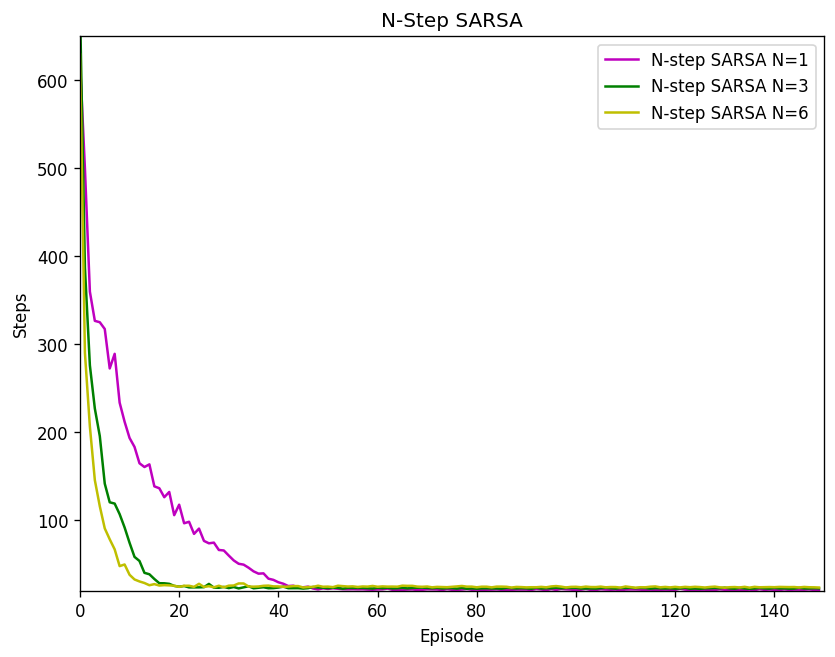

In [34]:
print(min(steps_total_sarsa_nstep_1))
print(min(steps_total_sarsa_nstep_3))
print(min(steps_total_sarsa_nstep_6))
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(20, 650)
plt.xlim(0, n_episodes)

# Plot the
ax.plot(steps_total_sarsa_nstep_1, "m", markersize=1)
ax.plot(steps_total_sarsa_nstep_3, "g", markersize=1)
ax.plot(steps_total_sarsa_nstep_6, "y", markersize=1)

ax.set_yscale("log")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend(
    [
        "N-step SARSA N=1",
        "N-step SARSA N=3",
        "N-step SARSA N=6",
    ]
)

plt.title("N-Step SARSA")

plt.plot()

In [21]:
def generate_episode(world: World, policy, start_state):
    current_state = start_state
    episode = []
    while not world.is_terminal(*current_state):
        # Get the possible actions and their probabilities that our policy says
        # that the agent should perform in the current state:
        possible_actions = policy(*current_state)

        # Pick a weighted random action:
        action = random.choices(
            population=list(possible_actions.keys()),
            weights=possible_actions.values(),
            k=1,
        )

        # Get the next state from the world
        next_state = world.get_next_state(current_state, action[0])

        # Get the reward for performing the action
        reward = world.get_reward(*next_state)

        # Save the state, action and reward for this time step in our episode
        episode.append([current_state, action[0], reward])

        # Move the agent to the new state
        current_state = next_state

    return episode


def mc_epsillon_soft(world, start_state, Q, policy, returns, gamma=0.9, epsilon=0.1):
    episode = generate_episode(world, lambda x, y: policy[(x, y)], start_state)

    G = 0
    # Iterate forward through the episode
    for idx in reversed(range(len(episode))):
        state, action, reward = episode[idx]
        G = gamma * G + reward
        # Check if the (state, action) pair has been seen before in the episode
        if (state, action) not in [(s, a) for s, a, _ in episode[:idx]]:
            returns[state][action].append(G)
            Q[state][action] = np.mean(returns[state][action])

            # Update policy to be greedy
            best_action = max(Q[state], key=Q[state].get)
            for a in ACTIONS:
                policy[state][a] = (
                    1 - epsilon + epsilon / abs(policy[state][a])
                    if a == best_action
                    else epsilon / abs(policy[state][a])
                )

    return Q, policy, returns, len(episode)

In [46]:

ACTIONS = ("up", "down", "left", "right")
world = World(10, 10)
world.add_terminal(9, 9, "+")
world.add_obstacle(6, 7)
world.add_obstacle(2, 2)
display(pd.DataFrame(world.grid.T))

n_episodes = 300
instances = 150
steps_total_sarsa_nstep_10 = [0] * n_episodes
steps_total_mc = [0] * n_episodes

for i in tqdm(range(instances)):
    Q = {}
    policy = {}
    returns = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}
            policy[(x, y)] = {action: 1 / len(ACTIONS) for action in ACTIONS}
            returns[(x, y)] = {action: [] for action in ACTIONS}

    for i in range(n_episodes):
        Q, policy, returns, steps = mc_epsillon_soft(
            world=world,
            start_state=(0, 0),
            Q=Q,
            policy=policy,
            returns=returns,
            gamma=0.9,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_mc = [sum(values) for values in zip(steps_total_mc, steps_temp)]

for i in tqdm(range(instances)):
    Q = {}
    steps_temp = []
    for x in range(world.width):
        for y in range(world.height):
            Q[(x, y)] = {action: 0.0 for action in ACTIONS}

    for i in range(n_episodes):
        Q, steps = n_step_SARSA(
            world=world,
            start_state=(0, 0),
            policy=greedy_policy,
            Q=Q,
            n=10,
            gamma=0.9,
            alpha=0.1,
            epsilon=0.1,
        )
        steps_temp.append(steps)

    steps_total_sarsa_nstep_10 = [
        sum(values) for values in zip(steps_total_sarsa_nstep_10, steps_temp)
    ]

steps_total_sarsa_nstep_10 = [value / instances for value in steps_total_sarsa_nstep_10]
steps_total_mc = [value / instances for value in steps_total_mc]

,0,1,2,3,4,5,6,7,8,9
0,,,,,,,,,,
1,,,,,,,,,,
2,,,#,,,,,,,
3,,,,,,,,,,
4,,,,,,,,,,
5,,,,,,,,,,
6,,,,,,,,,,
7,,,,,,,#,,,
8,,,,,,,,,,
9,,,,,,,,,,+


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:08<00:00, 18.01it/s]


65.36
23.473333333333333


[]

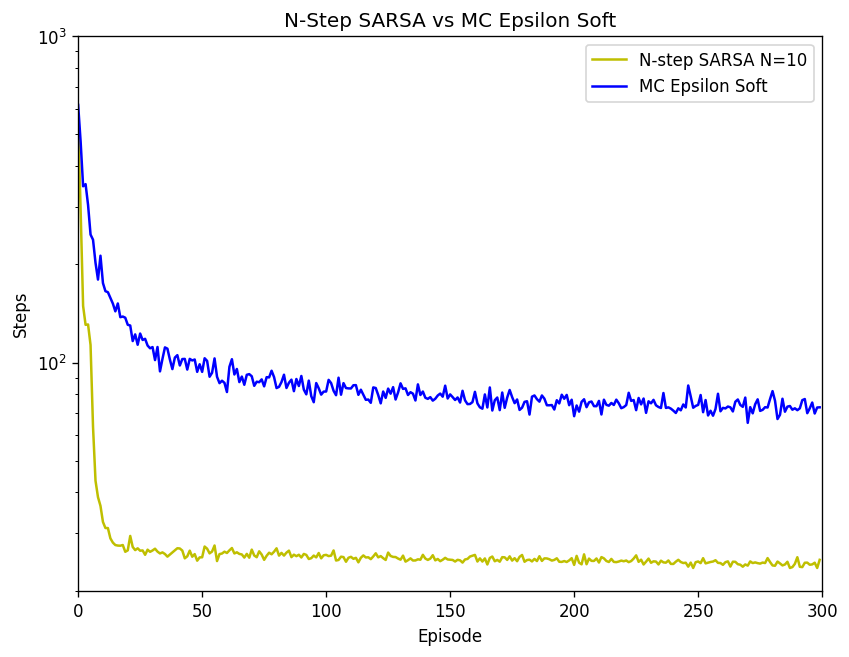

In [47]:
print(min(steps_total_mc))
print(min(steps_total_sarsa_nstep_10))
fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(1, 1, 1)
plt.ylim(20, 1000)
plt.xlim(0, n_episodes)

# Plot the
ax.plot(steps_total_sarsa_nstep_10, "y", markersize=1)
ax.plot(steps_total_mc, "b", markersize=1)

ax.set_yscale("log")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend(
    [
        "N-step SARSA N=10",
        "MC Epsilon Soft",
    ]
)

plt.title("N-Step SARSA vs MC Epsilon Soft")

plt.plot()